# OpTaliX: Transverse ray fan plot with Python (plotly)

This section describes how an OpTaliX macro "ray_fan.mac" can be used to write the transverse ray fan data of an optical system opened in OpTaliX (here: Mobile_US20070024958A1.OTX) to an ascii file. This file is then read with Python and the transverse ray fans are plotted with "plotly". 

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr  6 15:52:19 2022

@author: herbst
"""
import numpy as np
import matplotlib.pylab as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.colors import n_colors
import time 

t0 = time.perf_counter()


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

filename_py = r'C:\Work\OpTaliX\Test\RAY_FAN_PY.txt'
nwavelengths = int(np.loadtxt(filename_py, comments = 'C',max_rows=1)[0])
nfields = int(np.loadtxt(filename_py, comments = 'C',max_rows=1)[1])
wavelengths = np.loadtxt(filename_py, comments = 'C',skiprows = 2, max_rows=nwavelengths)[:,1]
fields = np.loadtxt(filename_py, comments = 'C',skiprows = 2+nwavelengths, max_rows=nfields)

rayfandata_py = np.loadtxt(filename_py, comments = 'C', skiprows = nwavelengths+2+nfields)

filename_px = r'C:\Work\OpTaliX\Test\RAY_FAN_PX.txt'
rayfandata_px = np.loadtxt(filename_px, comments = 'C', skiprows = nwavelengths+2+nfields)

n_fields = len(fields)
Lim = 0.02    # mm
#nwavelengths = 3

rayfandata_px_L= []
rayfandata_py_L = []
rayfandata_PY0_L = []
for w in range(0, nwavelengths):
    #print("w = ", w)
    rayfandata_px_LL = []
    rayfandata_py_LL = []
    rayfandata_px0 = rayfandata_px[rayfandata_px[:,0]==w+1]
    rayfandata_py0 = rayfandata_py[rayfandata_py[:,0]==w+1]                 # select data by wavelength
    

    
    for i in range(0, n_fields):
        rayfandata_px_LL.append(rayfandata_px0[rayfandata_px0[:,1]==i+1])
        rayfandata_PY = rayfandata_py0[rayfandata_py0[:,1]==i+1]            # select data by field
        

        if w == 0:
            rayfandata_PY0 = rayfandata_PY[np.where(rayfandata_PY[:,2] == find_nearest( rayfandata_PY[:,2], value = 0))[0],3][0]
            rayfandata_PY0_L.append(rayfandata_PY0)
        rayfandata_PY[:,3] -= rayfandata_PY0_L[i]
        #print("i = ", i, " , rayfandata_PY0: ", rayfandata_PY0)
        rayfandata_py_LL.append(rayfandata_PY)
    rayfandata_px_L.append(rayfandata_px_LL)
    rayfandata_py_L.append(rayfandata_py_LL)
    

plot = 1
if plot:
    
    
    if 0:
        import plotly.express as px
        
        fig = px.line(x=rayfandata_px[:,0], y=rayfandata_px[:,1],line_shape="spline")
        fig.show(renderer="browser")
    Titles = ('tangential (ey over py)','sagittal (ex over px)')
    names = ('field 1','field 2', 'field 3', 'field4')
    
    def to_rgb(name):
        from matplotlib import colors
        import matplotlib.cm
        C = colors.to_rgba(name)
        c = 'rgb'+str((C[0], C[1], C[2]))
        return c
    # with OpTaliX Field colors:
    #colors = (to_rgb('blue'),to_rgb('green'),to_rgb('red'))#, to_rgb('magenta'), to_rgb('cyan'),to_rgb('yellow'), to_rgb('orange'), to_rgb('mediumpurple'), to_rgb('lightseagreen'))
    colors = px.colors.sample_colorscale("jet", [n/(nwavelengths -1) for n in range(nwavelengths)])
    # sort data by wavelength
    sortedw = np.argsort(wavelengths)
    
    row_L = np.array([1,2,3,4])
    fig = make_subplots(rows=n_fields,cols=2, vertical_spacing=0.1,
                      horizontal_spacing=0.1,
                      subplot_titles=Titles,
                      shared_yaxes='all',
                      x_title='normalized pupil coordinate (referenced to entrance pupil)',
                      y_title='transverse aberration e / mm')
    for w in range(0, nwavelengths):
        if w == 0:
            mode = 'lines'#'+markers'
            line = dict(shape = 'linear',dash = "dash")
        elif w == 1:
            mode = 'lines'
            line = dict(shape = 'linear')
        elif w == 2:
            line = dict(shape = 'linear',dash = "dot")
        for i in range(0, n_fields):
            if i == 0:
                showlegend1=True
                showlegend2=False
            else:
                showlegend1=False
                showlegend2=False
            
            fig.add_scatter(x=rayfandata_py_L[sortedw[w]][i][1:-1,2], y=rayfandata_py_L[sortedw[w]][i][1:-1,3], mode=mode, line = line, row = row_L[i], col=1, name=wavelengths[sortedw[w]], marker_color = colors[w], showlegend = showlegend2)
    
            fig.add_scatter(x=rayfandata_px_L[sortedw[w]][i][1:-1,2], y=rayfandata_px_L[sortedw[w]][i][1:-1,3], mode=mode, line = line, row = row_L[i], col=2, name=str(wavelengths[sortedw[w]]*1e3)+' nm', marker_color = colors[w], showlegend = showlegend1)
            
            if w == 0:
                fig.add_annotation(x=0, y=Lim*0.75,
                            text="XAN, YAN = ("+str(np.round(fields[i,1],decimals=2))+ ", "+str(np.round(fields[i,2],decimals=2))+')°',
                            showarrow=False,
                            arrowhead=0,
                            row = row_L[i],
                            col=1)
                fig.add_annotation(x=0, y=Lim*0.75,
                            text="XAN, YAN = ("+str(np.round(fields[i,1],decimals=2))+ ", "+str(np.round(fields[i,2],decimals=2))+')°',
                            showarrow=False,
                            arrowhead=0,
                            row = row_L[i],
                            col=2)

    fig.update_xaxes(range=[-1, 1], dtick=1/2)
    fig.update_yaxes(range=[-Lim, Lim], dtick=Lim/2)
    fig.update_layout(height=900, width=900, template= 'seaborn')  # 'simple_white'
    fig.show()

    
    
        
    
print("Elapsed time: ", np.round(time.perf_counter()-t0, decimals = 4), " s")

Elapsed time:  0.2359  s


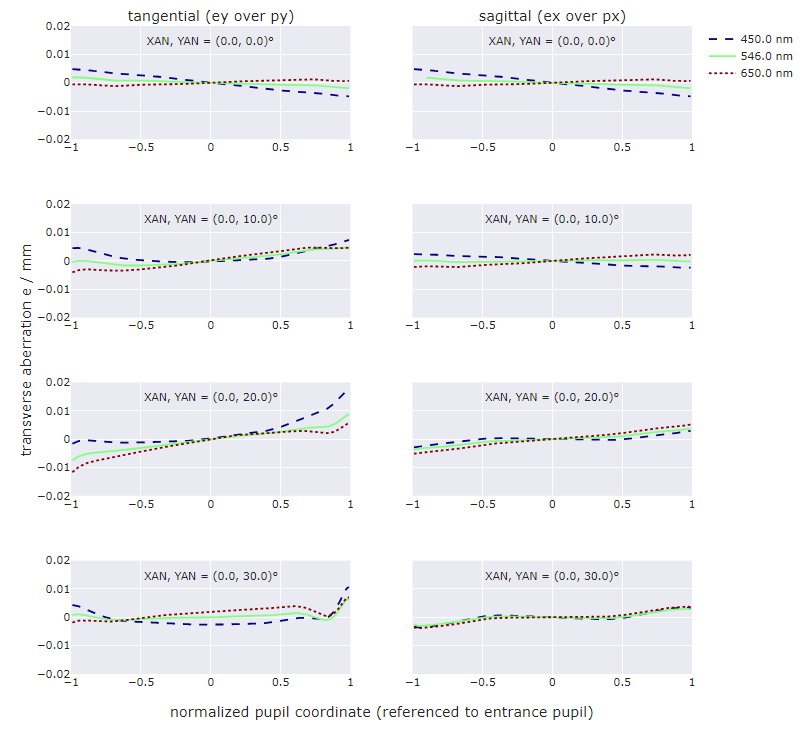

In [8]:
PATH = r'C:\Users\herbst\OpticalDesignDocu'
from IPython.display import Image
Image(filename = PATH + "\OpTaliX\plotly_transverse_aberration.png", width=1000, height=800)